# Feed Forward VQGAN_CLIP

Feed forward VQGAN-CLIP model, where the goal is to eliminate the need for optimizing the latent space of VQGAN for each input prompt. This is done by training a model that takes as input a text prompt, and returns as an output the VQGAN latent space, which is then transformed into an RGB image. The model is trained on a dataset of text prompts and can be used on unseen text prompts. The loss function is minimizing the distance between the CLIP generated image features and the CLIP input text features. Additionally, a diversity loss can be used to make increase the diversity of the generated images given the same prompt.

This notebooks shows how to use a pre-trained model for generating images.

In [ ]:
import os, sys
import torch

In [ ]:
!git clone https://github.com/jiaxuanchin/feed_forward_vqgan_clip

Cloning into 'feed_forward_vqgan_clip'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 782 (delta 12), reused 17 (delta 6), pack-reused 752
Receiving objects: 100% (782/782), 2.47 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [ ]:
cd feed_forward_vqgan_clip

/content/feed_forward_vqgan_clip


In [ ]:
!pip install -r requirements.txt

  Cloning https://github.com/CompVis/net2net to /tmp/pip-req-build-s0gxbt1j
  Running command git clone --filter=blob:none --quiet https://github.com/CompVis/net2net /tmp/pip-req-build-s0gxbt1j
  Resolved https://github.com/CompVis/net2net to commit 5311cb8495e378158be1f5374004eb9a3f7de992
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.1/708.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Modelling

In [ ]:
#check available models at https://github.com/mehdidc/feed_forward_vqgan_clip/releases
from download_weights import model_url, download
download("https://github.com/mehdidc/feed_forward_vqgan_clip/releases/download/0.1/vqgan_imagenet_f16_16384.yaml")
download("https://github.com/mehdidc/feed_forward_vqgan_clip/releases/download/0.1/vqgan_imagenet_f16_16384.ckpt")

In [ ]:
# troubleshoot
# !pip uninstall pytorch-lightning
# !pip install pytorch-lightning==1.6.5
# !python --version
# !pip uninstall torchmetrics
# !pip install torchmetrics==0.11.4

In [ ]:
from IPython.display import Image, HTML, display, clear_output
import torch
from main import load_vqgan_model, CLIP_DIM, CLIP_SIZE, CLIP_MEAN, CLIP_STD, clamp_with_grad, synth, load_clip_model, load_prior_model, load_model
import torchvision
import ipywidgets as widgets
from functools import lru_cache
import IPython
from download_weights import PRIOR_MODEL, model_url
import clip
from functools import lru_cache
# from base64 import b64encode
# from IPython.display import HTML
from tqdm import tqdm
from base64 import b64encode
from IPython.display import HTML
from PIL import Image

# Generate

In [ ]:
@lru_cache(maxsize=3)
def load(model_path, use_prior):
  print("Loading model...")
  if 'cloob' in model_path:
    download("https://ml.jku.at/research/CLOOB/downloads/checkpoints/cloob_rn50_yfcc_epoch_28.pt")
  #print("Selected model: ", model_path)
  if not os.path.exists(model_path):
    print("Downloading", model_path)
    url = model_url[model_path]
    !wget $url --output-document=$model_path
  net = load_model(model_path).to(device)
  config = net.config
  vqgan_config = config.vqgan_config
  vqgan_checkpoint = config.vqgan_checkpoint
  clip_model = config.clip_model
  clip_dim = CLIP_DIM[clip_model]
  if config.get("clip_model_path"):
    assert os.path.exists(config.clip_model_path)
  perceptor = load_clip_model(clip_model, path=config.get("clip_model_path")).eval().requires_grad_(False).to(device)
  vq = load_vqgan_model(vqgan_config, vqgan_checkpoint).to(device)
  z_min = vq.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
  z_max = vq.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

  if use_prior:
    prior_path = PRIOR_MODEL[model_path]
    if not os.path.exists(prior_path):
      url = model_url[prior_path]
      !wget $url --output-document=$prior_path
    prior_net = load_prior_model(PRIOR_MODEL[model_path]).to(device)
  else:
    prior_net = None
  return net, vq, perceptor, z_min, z_max, prior_net


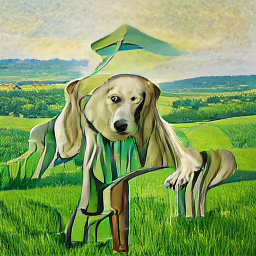

In [ ]:
# from PIL import Image
# import torchvision

def update(bt):
    global box
    global text
    global prior
    global grid_size
    global seed
    global model
    import random
    if seed.value != -1:
      torch.manual_seed(seed.value)
    model_path = model.value
    net, vq, perceptor, z_min, z_max, prior_net = load(model_path, prior.value)
    gs = grid_size.value
    with torch.no_grad():
        if not text.value:
          H = torch.randn(1, CLIP_DIM[net.config.clip_model]).to(device)
        else:
          toks = clip.tokenize([text.value], truncate=True)
          H = perceptor.encode_text(toks.to(device)).float()
        H = H.repeat(gs*gs, 1)
        if prior_net is not None:
          H = H.view(len(H), -1, 1, 1)
          H = prior_net.sample(H)
          H = H.view(len(H), -1)
        z = net(H)
        z = clamp_with_grad(z, z_min.min(),z_max.max())
        xr = synth(vq, z)
    grid = torchvision.utils.make_grid(xr.cpu(), nrow=gs)
    pil_image = torchvision.transforms.functional.to_pil_image(grid)

    output_path = "output.jpg"
    pil_image.save(output_path, "JPEG")
    print(f"Image saved as {output_path}")

    clear_output()
    display(box)
    display(pil_image)

text = widgets.Text(description="Text prompt", value="painting of a golden retriever standing on a lush and vast green field", layout=widgets.Layout(width='80%'))
btn = widgets.Button(description="Generate!")
grid_size = widgets.IntSlider(min=1, value=1, description="Grid size", max=8)
prior = widgets.Checkbox(value=False, description="Use prior?")
model = widgets.Dropdown(
    options=[url for url in model_url.keys() if not url.startswith("prior_")],
    value='cc12m_32x1024_mlp_mixer_openclip_laion2b_ViTB32_256x256_v0.4.th',
    description='Model:',
    disabled=False,
    layout={'width': 'max-content'},
)
btn.on_click(update)
seed = widgets.IntSlider(min=-1, max=1000, value=-1, description="Seed")
text.on_submit(update)
box = widgets.VBox(
    [
     widgets.HBox([text,]),
     widgets.HBox([btn,]),
     widgets.HBox([model, ]),
     widgets.HBox([grid_size]),
     widgets.HBox([prior, ]),
    widgets.HBox([seed,])

  ])
box

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open("output.jpg")

inputs = processor(text=["painting of a golden retriever standing on green grass"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

logits_per_image

tensor([[35.1414]], grad_fn=<TBackward0>)

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open("vqganclip.png")

inputs = processor(text=["painting of a golden retriever standing on green grass in cubism"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

logits_per_image

tensor([[58.0120]], grad_fn=<TBackward0>)